Clustering - Uber
1. Prepración de datos: variables numéricas se deben normalizar y variables categóricas se crean dummies
2. Aprendizaje del modelo: Kmeans, método del codo/rodilla
3. Evaluación del modelo: Inertia, silueta
4. Perfilamiento: Descripción de centroides.

In [1]:
import pandas as pd
import numpy as np #matrices y vectores
import matplotlib.pyplot as plt #grafica

In [2]:
data = pd.read_excel("./data/Base de datos UBER.xlsx")
data.head() #Listar las primeras filas de data

,Date,Time,Booking Status,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Payment Method
0,2024-03-23,12:29:38,No Driver Found,0.0,0.0,No,No Report,No,No Report,No,No Report,0,0.00,No Report
1,2024-11-29,18:01:39,Incomplete,4.9,0.0,No,No Report,No,No Report,Si,Vehicle Breakdown,237,5.73,UPI
2,2024-08-23,08:56:10,Completed,13.4,0.0,No,No Report,No,No Report,No,No Report,627,13.58,Debit Card
3,2024-10-21,17:17:25,Completed,13.1,0.0,No,No Report,No,No Report,No,No Report,416,34.02,UPI
4,2024-09-16,22:08:00,Completed,5.3,0.0,No,No Report,No,No Report,No,No Report,737,48.21,UPI


In [3]:
#Eliminar una columna
#df_prueba= data.drop('Booking Status',axis=1)
#df_prueba.head()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Date                               150000 non-null  datetime64[ns]
 1   Time                               150000 non-null  object        
 2   Booking Status                     150000 non-null  object        
 3   Avg VTAT                           150000 non-null  float64       
 4   Avg CTAT                           150000 non-null  float64       
 5   Cancelled Rides by Customer        150000 non-null  object        
 6   Reason for cancelling by Customer  150000 non-null  object        
 7   Cancelled Rides by Driver          150000 non-null  object        
 8   Driver Cancellation Reason         150000 non-null  object        
 9   Incomplete Rides                   150000 non-null  object        
 10  Incomplete Rides Rea

In [5]:
#corrección de tipo de datos
data['Booking Status']=data['Booking Status'].astype('category')
data['Cancelled Rides by Customer']=data['Cancelled Rides by Customer'].astype('category')
data['Reason for cancelling by Customer']=data['Reason for cancelling by Customer'].astype('category')
data['Cancelled Rides by Driver']=data['Cancelled Rides by Driver'].astype('category')
data['Driver Cancellation Reason']=data['Driver Cancellation Reason'].astype('category')
data['Incomplete Rides']=data['Incomplete Rides'].astype('category')
data['Incomplete Rides Reason']=data['Incomplete Rides Reason'].astype('category')
data['Payment Method']=data['Payment Method'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Date                               150000 non-null  datetime64[ns]
 1   Time                               150000 non-null  object        
 2   Booking Status                     150000 non-null  category      
 3   Avg VTAT                           150000 non-null  float64       
 4   Avg CTAT                           150000 non-null  float64       
 5   Cancelled Rides by Customer        150000 non-null  category      
 6   Reason for cancelling by Customer  150000 non-null  category      
 7   Cancelled Rides by Driver          150000 non-null  category      
 8   Driver Cancellation Reason         150000 non-null  category      
 9   Incomplete Rides                   150000 non-null  category      
 10  Incomplete Rides Rea

In [6]:
#data.hist()

In [7]:
#data.plot(kind='box')

In [8]:
#data['Incapacidades'].plot(kind='box') #No es un error

In [9]:
#data['Casado'].value_counts().plot(kind='bar')

In [10]:
#Cargar librería para Profiling
#from ydata_profiling import ProfileReport
#profile_data=ProfileReport(data, minimal= True)
#profile_data

In [11]:
data=data.copy()


In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Re-create the 'DateTime' column by combining 'Date' and 'Time'
data['DateTime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str), errors='coerce')

# Drop the original 'Date' and 'Time' columns
data = data.drop(['Date', 'Time'], axis=1)


# --- 1. Convertir DateTime ---
# The 'DateTime' column already exists and is in datetime format
data["fecha"] = data["DateTime"]
data["hora"] = data["DateTime"].dt.hour

# --- 2. Extraer características de fecha ---
data["anio"] = data["fecha"].dt.year
data["mes"] = data["fecha"].dt.month
data["dia_semana"] = data["fecha"].dt.dayofweek   # 0=lunes, 6=domingo

# --- 3. Codificar hora de manera cíclica ---
data["hora_sin"] = np.sin(2 * np.pi * data["hora"] / 24)
data["hora_cos"] = np.cos(2 * np.pi * data["hora"] / 24)

# --- 4. (Opcional) Discretizar hora en franjas horarias ---
def discretizar_hora(hora):
    if 5 <= hora < 12:
        return "mañana"
    elif 12 <= hora < 18:
        return "tarde"
    elif 18 <= hora < 24:
        return "noche"
    else:
        return "madrugada"

data["franja_horaria"] = data["hora"].apply(discretizar_hora)

# Convertir franja_horaria en variables dummy
data = pd.get_dummies(data, columns=["franja_horaria"], dtype=int)

# --- 5. Selección de variables para clustering ---
# Include the new time-based features in the clustering features
features = ["Avg VTAT", "Avg CTAT", "Booking Value", "Ride Distance", "dia_semana", "mes", "hora_sin", "hora_cos"] + \
           [col for col in data.columns if "franja_horaria_" in col] + \
           [col for col in data.columns if "Booking Status_" in col] + \
           [col for col in data.columns if "Cancelled Rides by Customer_" in col] + \
           [col for col in data.columns if "Reason for cancelling by Customer_" in col] + \
           [col for col in data.columns if "Cancelled Rides by Driver_" in col] + \
           [col for col in data.columns if "Driver Cancellation Reason_" in col] + \
           [col for col in data.columns if "Incomplete Rides_" in col] + \
           [col for col in data.columns if "Incomplete Rides Reason_" in col] + \
           [col for col in data.columns if "Payment Method_" in col]


X = data[features]

# --- 6. Normalización ---
# Note: Numerical columns were already normalized using MinMaxScaler in a previous step.
# StandardScaler is used here for the new time-based features if needed, or you can use the previously fitted MinMaxScaler.
# For consistency, I will assume you want to scale all features together using StandardScaler for the clustering input.
# If you prefer to keep the MinMaxScaler for the original numerical features, let me know.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Variables used in clustering:", features)
print("Shape of X_scaled:", X_scaled.shape)

Variables used in clustering: ['Avg VTAT', 'Avg CTAT', 'Booking Value', 'Ride Distance', 'dia_semana', 'mes', 'hora_sin', 'hora_cos', 'franja_horaria_madrugada', 'franja_horaria_mañana', 'franja_horaria_noche', 'franja_horaria_tarde']
Shape of X_scaled: (150000, 12)


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Booking Status                     150000 non-null  category      
 1   Avg VTAT                           150000 non-null  float64       
 2   Avg CTAT                           150000 non-null  float64       
 3   Cancelled Rides by Customer        150000 non-null  category      
 4   Reason for cancelling by Customer  150000 non-null  category      
 5   Cancelled Rides by Driver          150000 non-null  category      
 6   Driver Cancellation Reason         150000 non-null  category      
 7   Incomplete Rides                   150000 non-null  category      
 8   Incomplete Rides Reason            150000 non-null  category      
 9   Booking Value                      150000 non-null  int64         
 10  Ride Distance       

In [14]:
data.head()

,Booking Status,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,...,hora,anio,mes,dia_semana,hora_sin,hora_cos,franja_horaria_madrugada,franja_horaria_mañana,franja_horaria_noche,franja_horaria_tarde
0,No Driver Found,0.0,0.0,No,No Report,No,No Report,No,No Report,0,...,12,2024,3,5,1.224647e-16,-1.000000e+00,0,0,0,1
1,Incomplete,4.9,0.0,No,No Report,No,No Report,Si,Vehicle Breakdown,237,...,18,2024,11,4,-1.000000e+00,-1.836970e-16,0,0,1,0
2,Completed,13.4,0.0,No,No Report,No,No Report,No,No Report,627,...,8,2024,8,4,8.660254e-01,-5.000000e-01,0,1,0,0
3,Completed,13.1,0.0,No,No Report,No,No Report,No,No Report,416,...,17,2024,10,0,-9.659258e-01,-2.588190e-01,0,0,0,1
4,Completed,5.3,0.0,No,No Report,No,No Report,No,No Report,737,...,22,2024,9,0,-5.000000e-01,8.660254e-01,0,0,1,0


In [15]:
#Eliminar una columna
df_prueba = data.copy()
#df_prueba.info()
df_prueba = df_prueba.drop(['fecha','anio','DateTime','hora_cos','hora_sin','hora'], axis=1)
df_prueba.head()

,Booking Status,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Payment Method,mes,dia_semana,franja_horaria_madrugada,franja_horaria_mañana,franja_horaria_noche,franja_horaria_tarde
0,No Driver Found,0.0,0.0,No,No Report,No,No Report,No,No Report,0,0.00,No Report,3,5,0,0,0,1
1,Incomplete,4.9,0.0,No,No Report,No,No Report,Si,Vehicle Breakdown,237,5.73,UPI,11,4,0,0,1,0
2,Completed,13.4,0.0,No,No Report,No,No Report,No,No Report,627,13.58,Debit Card,8,4,0,1,0,0
3,Completed,13.1,0.0,No,No Report,No,No Report,No,No Report,416,34.02,UPI,10,0,0,0,0,1
4,Completed,5.3,0.0,No,No Report,No,No Report,No,No Report,737,48.21,UPI,9,0,0,0,1,0


In [16]:
df_prueba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Booking Status                     150000 non-null  category
 1   Avg VTAT                           150000 non-null  float64 
 2   Avg CTAT                           150000 non-null  float64 
 3   Cancelled Rides by Customer        150000 non-null  category
 4   Reason for cancelling by Customer  150000 non-null  category
 5   Cancelled Rides by Driver          150000 non-null  category
 6   Driver Cancellation Reason         150000 non-null  category
 7   Incomplete Rides                   150000 non-null  category
 8   Incomplete Rides Reason            150000 non-null  category
 9   Booking Value                      150000 non-null  int64   
 10  Ride Distance                      150000 non-null  float64 
 11  Payment Method            

In [17]:
#Normalización de variables numéricas
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler ()
variables_a_normalizar=['Avg VTAT','Avg CTAT', 'Booking Value', 'Ride Distance','mes','dia_semana','franja_horaria_madrugada','franja_horaria_mañana','franja_horaria_noche','franja_horaria_tarde']
min_max_scaler.fit(df_prueba[variables_a_normalizar]) #Ajuste de parámetro
df_prueba[variables_a_normalizar]=min_max_scaler.transform(df_prueba[variables_a_normalizar])
df_prueba[variables_a_normalizar].head()

,Avg VTAT,Avg CTAT,Booking Value,Ride Distance,mes,dia_semana,franja_horaria_madrugada,franja_horaria_mañana,franja_horaria_noche,franja_horaria_tarde
0,0.000,0.0,0.000000,0.0000,0.181818,0.833333,0.0,0.0,0.0,1.0
1,0.245,0.0,0.055413,0.1146,0.909091,0.666667,0.0,0.0,1.0,0.0
2,0.670,0.0,0.146598,0.2716,0.636364,0.666667,0.0,1.0,0.0,0.0
3,0.655,0.0,0.097264,0.6804,0.818182,0.000000,0.0,0.0,0.0,1.0
4,0.265,0.0,0.172317,0.9642,0.727273,0.000000,0.0,0.0,1.0,0.0


In [18]:
#Se crean dummies para las variables categóricas
data= pd.get_dummies(df_prueba, columns=['Booking Status','Cancelled Rides by Customer','Reason for cancelling by Customer','Cancelled Rides by Driver','Driver Cancellation Reason', 'Incomplete Rides','Incomplete Rides Reason', 'Payment Method'], drop_first= True, dtype=int)
data.head()

,Avg VTAT,Avg CTAT,Booking Value,Ride Distance,mes,dia_semana,franja_horaria_madrugada,franja_horaria_mañana,franja_horaria_noche,franja_horaria_tarde,...,Driver Cancellation Reason_The customer was coughing/sick,Incomplete Rides_Si,Incomplete Rides Reason_No Report,Incomplete Rides Reason_Other Issue,Incomplete Rides Reason_Vehicle Breakdown,Payment Method_Credit Card,Payment Method_Debit Card,Payment Method_No Report,Payment Method_UPI,Payment Method_Uber Wallet
0,0.000,0.0,0.000000,0.0000,0.181818,0.833333,0.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,1,0,0
1,0.245,0.0,0.055413,0.1146,0.909091,0.666667,0.0,0.0,1.0,0.0,...,0,1,0,0,1,0,0,0,1,0
2,0.670,0.0,0.146598,0.2716,0.636364,0.666667,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,0
3,0.655,0.0,0.097264,0.6804,0.818182,0.000000,0.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,1,0
4,0.265,0.0,0.172317,0.9642,0.727273,0.000000,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,1,0


2. Aprendizaje del Modelo
* Método codo/rodilla
* Aplicar kmeans

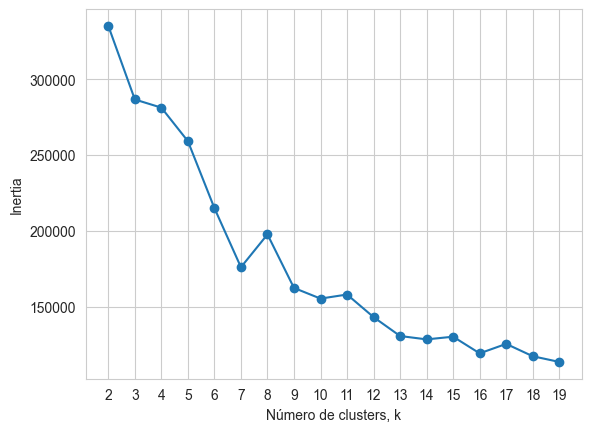

In [19]:
#Metodo de la rodilla: silueta
from sklearn.cluster import KMeans
ks=range (2,20) #Crear valores del 2 al 20
inertias=[]
for k in ks:
  kmeans=KMeans(n_clusters=k)
  kmeans.fit(data)
  inertias.append(kmeans.inertia_)
#Graficar cantidad de cluster vs inertias
plt.plot(ks,inertias, '-o')
plt.xlabel('Número de clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

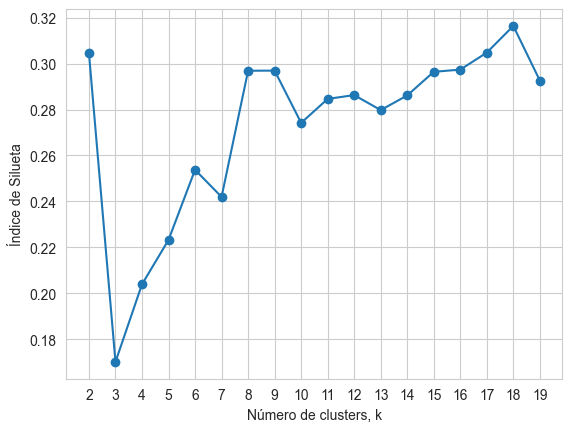

In [20]:
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ks = range(2, 20)  # Crear valores del 2 al 19
siluetas = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)  # Es buena práctica fijar random_state
    kmeans.fit(data)
    sil = metrics.silhouette_score(data, kmeans.labels_, sample_size=10000, random_state=42)
    siluetas.append(sil)

# Graficar número de clusters vs siluetas
plt.plot(ks, siluetas, '-o')
plt.xlabel('Número de clusters, k')
plt.ylabel('Índice de Silueta')
plt.xticks(ks)
plt.show()

In [21]:
k=7
model=KMeans(n_clusters=k, max_iter=300)
model.fit(data) #100% datos

,n_clusters,7
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


3. Evaluación del Modelo
* Inertia: Valor pequeño esperado
* Silueta: Valor positivo esperado, idealmente mayor a 0.5

In [22]:
#Evaluación

from sklearn import metrics
print('Inertia o cohesión:', model.inertia_)
sil=metrics.silhouette_score(data,model.labels_, sample_size=10000, random_state=42)
print('Silueta:', sil)


Inertia o cohesión: 197193.65733336774
Silueta: 0.27626035469799737


4. Perfilamiento
Descripción de centroides

In [23]:
#Centroides almacenados dentro del modelo
model.cluster_centers_

array([[ 4.26384257e-01,  6.21591775e-01,  1.18754771e-01,
         5.19282477e-01,  5.00497650e-01,  4.97950705e-01,
         1.30705744e-01,  8.69294256e-01, -4.16333634e-15,
         9.32587341e-15, -5.27355937e-15,  1.00000000e+00,
        -1.34614542e-15,  2.81719092e-15,  2.81719092e-15,
        -3.98986399e-16,  1.16226473e-16, -5.01335085e-16,
         1.00000000e+00,  5.44703171e-16, -5.27355937e-15,
         7.84095011e-16,  1.00000000e+00,  2.56739074e-16,
         6.17561557e-16, -1.34614542e-15,  1.00000000e+00,
        -6.14092110e-16, -9.36750677e-17,  1.85334905e-01,
         1.47043962e-01,  5.16253706e-15, -2.05391260e-15,
         2.21829207e-01],
       [ 3.75097593e-01,  1.39332990e-14,  2.22044605e-15,
         1.56541446e-14,  4.98067340e-01,  4.95475309e-01,
         4.52962963e-02,  3.00962963e-01,  3.28962963e-01,
         3.24777778e-01,  1.00000000e+00,  3.28626015e-14,
        -1.64451786e-15,  4.20496971e-15,  4.20496971e-15,
        -4.75314232e-16, -4.05

In [24]:
#Centroides de los cluster se conviertan en un dataframe de pandas
centroides=pd.DataFrame(model.cluster_centers_, columns=data.columns.values)
centroides.round(1)

,Avg VTAT,Avg CTAT,Booking Value,Ride Distance,mes,dia_semana,franja_horaria_madrugada,franja_horaria_mañana,franja_horaria_noche,franja_horaria_tarde,...,Driver Cancellation Reason_The customer was coughing/sick,Incomplete Rides_Si,Incomplete Rides Reason_No Report,Incomplete Rides Reason_Other Issue,Incomplete Rides Reason_Vehicle Breakdown,Payment Method_Credit Card,Payment Method_Debit Card,Payment Method_No Report,Payment Method_UPI,Payment Method_Uber Wallet
0,0.4,0.6,0.1,0.5,0.5,0.5,0.1,0.9,-0.0,0.0,...,0.0,-0.0,1.0,-0.0,-0.0,0.2,0.1,0.0,-0.0,0.2
1,0.4,0.0,0.0,0.0,0.5,0.5,0.0,0.3,0.3,0.3,...,0.3,-0.0,1.0,0.0,-0.0,-0.0,0.0,1.0,-0.0,0.0
2,0.4,0.6,0.1,0.5,0.5,0.5,-0.0,0.0,-0.0,1.0,...,0.0,0.1,0.9,0.0,0.0,0.1,0.1,-0.0,0.4,0.1
3,0.4,0.6,0.1,0.5,0.5,0.5,-0.0,0.0,1.0,-0.0,...,0.0,0.1,0.9,0.0,0.0,0.1,0.1,-0.0,0.5,0.1
4,0.6,-0.0,0.0,-0.0,0.5,0.5,0.0,0.3,0.3,0.3,...,0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,0.0
5,0.4,0.6,0.1,0.5,0.5,0.5,0.1,0.9,-0.0,0.0,...,0.0,0.2,0.8,0.1,0.1,0.0,0.0,0.0,0.9,0.0
6,-0.0,-0.0,0.0,-0.0,0.5,0.5,0.0,0.3,0.3,0.3,...,0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,0.0


In [25]:
#Se realiza una des-normalización centroides
centroides[variables_a_normalizar]=min_max_scaler.inverse_transform(centroides[variables_a_normalizar])
centroides.round(0)

,Avg VTAT,Avg CTAT,Booking Value,Ride Distance,mes,dia_semana,franja_horaria_madrugada,franja_horaria_mañana,franja_horaria_noche,franja_horaria_tarde,...,Driver Cancellation Reason_The customer was coughing/sick,Incomplete Rides_Si,Incomplete Rides Reason_No Report,Incomplete Rides Reason_Other Issue,Incomplete Rides Reason_Vehicle Breakdown,Payment Method_Credit Card,Payment Method_Debit Card,Payment Method_No Report,Payment Method_UPI,Payment Method_Uber Wallet
0,9.0,28.0,508.0,26.0,7.0,3.0,0.0,1.0,-0.0,0.0,...,0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0
1,8.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,1.0,-0.0,0.0
2,8.0,27.0,507.0,25.0,6.0,3.0,-0.0,0.0,-0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0
3,8.0,27.0,508.0,25.0,6.0,3.0,-0.0,0.0,1.0,-0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0
4,13.0,-0.0,0.0,-0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,0.0
5,8.0,26.0,511.0,23.0,6.0,3.0,0.0,1.0,-0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,-0.0,-0.0,0.0,-0.0,6.0,3.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,0.0


Descripción de perfiles
* Perfil 0: Salario de 4.800.000, no hijo, incapacidades 7 días al año, 15 años de antigüedad, casado si, no vivienda, mujer y sindicato
* Perfil 1:
* Perfil 2:


In [26]:
#En el dataframe original, se adiciona el cluster asignado a cada registro
data['cluster']=model.labels_
data.head()

,Avg VTAT,Avg CTAT,Booking Value,Ride Distance,mes,dia_semana,franja_horaria_madrugada,franja_horaria_mañana,franja_horaria_noche,franja_horaria_tarde,...,Incomplete Rides_Si,Incomplete Rides Reason_No Report,Incomplete Rides Reason_Other Issue,Incomplete Rides Reason_Vehicle Breakdown,Payment Method_Credit Card,Payment Method_Debit Card,Payment Method_No Report,Payment Method_UPI,Payment Method_Uber Wallet,cluster
0,0.000,0.0,0.000000,0.0000,0.181818,0.833333,0.0,0.0,0.0,1.0,...,0,1,0,0,0,0,1,0,0,6
1,0.245,0.0,0.055413,0.1146,0.909091,0.666667,0.0,0.0,1.0,0.0,...,1,0,0,1,0,0,0,1,0,3
2,0.670,0.0,0.146598,0.2716,0.636364,0.666667,0.0,1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,0.655,0.0,0.097264,0.6804,0.818182,0.000000,0.0,0.0,0.0,1.0,...,0,1,0,0,0,0,0,1,0,2
4,0.265,0.0,0.172317,0.9642,0.727273,0.000000,0.0,0.0,1.0,0.0,...,0,1,0,0,0,0,0,1,0,3


<Axes: ylabel='count'>

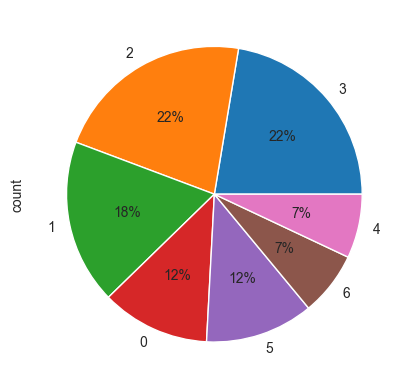

In [27]:
#Cantidad de datos en cada clúster
data['cluster'].value_counts().plot(kind='pie',autopct='%.0f%%')

In [28]:
#Almacenar resultados
data.to_excel('./resultados_KMeans.xlsx')
centroides.to_excel('./centroides_KMeans.xlsx')